Loading and preparing data...
✅ final_df created successfully.

--- Running Scenario 3 ---
  Age_Group sales_channel Total_Revenue  Total_Units_Sold
0     18-29        Online    $34,504.50                67
1     18-29        Retail    $27,242.40                64
2     30-39        Online    $57,556.20                71
3     30-39        Retail    $54,009.00                85
4     40-49        Online    $48,083.10                72
5     40-49        Retail    $36,032.40                61
6     50-59        Online    $31,174.00                39
7     50-59        Retail    $30,344.60                40
8       60+        Online    $35,745.00                75
9       60+        Retail    $32,805.00                47


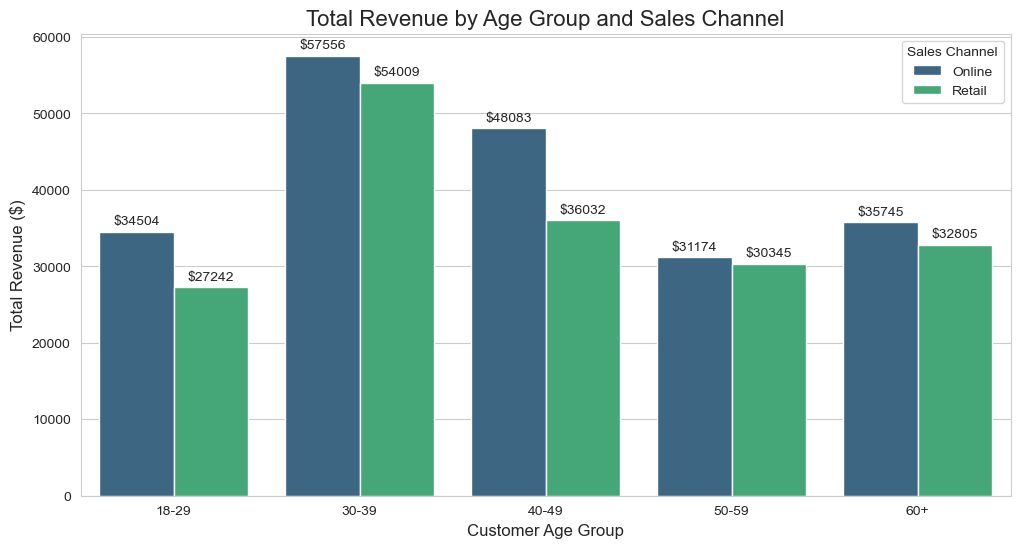

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. SETUP & DATA CREATION (Must run this first!) ---
FILES = {
    'sales': '../data/sales.csv',
    'customers': '../data/customers.csv',
    'employees': '../data/employees.csv',
    'products': '../data/products.csv',
    'sales_commission': '../data/sales_commission.csv'
}

def load_data(files):
    dfs = {}
    for name, path in files.items():
        if name == 'sales':
            try:
                dfs[name] = pd.read_csv(path, parse_dates=['sale_date', 'dispatch_date'])
            except:
                dfs[name] = pd.read_csv(path)
        else:
            dfs[name] = pd.read_csv(path)
    return dfs

def merge_data(dfs):
    # Ensure category exists
    if 'category' not in dfs['products'].columns:
        dfs['products']['category'] = 'Uncategorized'
        
    master_df = dfs['sales'].merge(
        dfs['products'][['product_id', 'product_name', 'price', 'cost_price', 'category']],
        on='product_id', how='left', suffixes=('_sales', '_product')
    )
    master_df = master_df.merge(
        dfs['employees'][['employee_id', 'name', 'job_code']], 
        on='employee_id', how='left'
    ).rename(columns={'name': 'employee_name'})
    
    # Customer merge (using 'name' as discussed)
    master_df = master_df.merge(
        dfs['customers'][['customer_id', 'name', 'age']],
        on='customer_id', how='left'
    ).rename(columns={'name': 'customer_name'})
    
    return master_df

def feature_engineer(df):
    df['Revenue'] = df['quantity'] * df['price']
    return df

# --- EXECUTE SETUP ---
print("Loading and preparing data...")
dfs = load_data(FILES)
master_df = merge_data(dfs)
final_df = feature_engineer(master_df)
print("✅ final_df created successfully.")


# --- 2. SCENARIO 3: Customer Demographics Analysis ---
print("\n--- Running Scenario 3 ---")

# Create Age Segments
age_bins = [17, 29, 39, 49, 59, 120]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60+']
final_df['Age_Group'] = pd.cut(final_df['age'], bins=age_bins, labels=age_labels)

# Group by Age Group AND Sales Channel
demographics_analysis = final_df.groupby(['Age_Group', 'sales_channel'], observed=False)[['Revenue', 'quantity']].sum().reset_index()
demographics_analysis.rename(columns={'quantity': 'Total_Units_Sold', 'Revenue': 'Total_Revenue'}, inplace=True)

# Display Table
display_table = demographics_analysis.copy()
display_table['Total_Revenue'] = display_table['Total_Revenue'].apply(lambda x: f"${x:,.2f}")
print(display_table)

# Plot Chart
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
chart = sns.barplot(
    data=demographics_analysis,
    x='Age_Group',
    y='Total_Revenue',
    hue='sales_channel',
    palette='viridis'
)
plt.title('Total Revenue by Age Group and Sales Channel', fontsize=16)
plt.xlabel('Customer Age Group', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.legend(title='Sales Channel')
for container in chart.containers:
    chart.bar_label(container, fmt='$%.0f', padding=3)
plt.show()